In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import tensorflow as tf
from tensorflow import keras
import time
from PIL import Image
# %matplotlib notebook

## generating input data

In [39]:
x = np.linspace(0,1,100)

In [40]:
def get_wave_y(x, d, w0):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

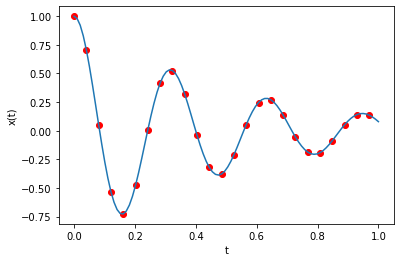

In [41]:
d,w0 =2,20
y = get_wave_y(x,d=2,w0=20)
x_data = x[0::4]
y_data = y[0::4]
plt.plot(x,y)
plt.scatter(x_data, y_data, c='red')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [42]:
x_data.shape

(25,)

In [43]:
x_new = x.reshape(-1,1)
y_new = y.reshape(-1,1)
x_data_new = x.reshape(-1,1)
y_data_new = y.reshape(-1,1)
x_new.shape

(100, 1)

```plt.plot()``` works for both (n,) numpy arrays and (n,1) numpy arrays (obtained using ```reshape(-1,1)```)

(n,1) array is for tensorflow/keras NN model

## keras NN model 
* optimizer  = ```RMSprop```
* loss       = ```total_loss```
* activation = ```tanh```

In [65]:
nodes = 20
model = keras.Sequential([
    keras.layers.Dense(nodes,activation=keras.activations.tanh,input_shape=(1,)),
    keras.layers.Dense(nodes,activation=keras.activations.tanh),
    keras.layers.Dense(1,activation=keras.activations.tanh)
])

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
#     loss=keras.losses.MeanSquaredError(),
    loss=total_loss,
)

### to get one final plot

In [22]:
p=1

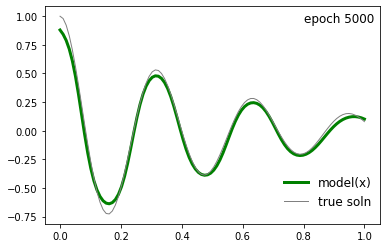

In [37]:
epochs = 5000
files = []

model.fit(x_data,y_data,verbose=0, epochs=epochs)
plot_curve(x,y,model(x), epochs)

# to save the plots for each iteration
files.append(f"wave_final_plots/single_{p:004}.png")
plt.savefig(f'wave_final_plots/single{p:004}', dpi=100, facecolor='white')
p+=1

### to get plots for each epoch

<IPython.core.display.Javascript object>


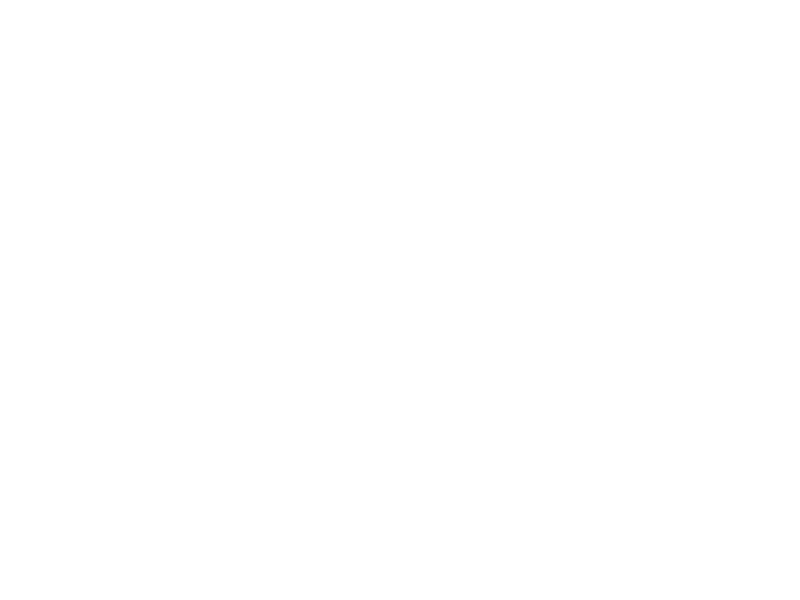

KeyboardInterrupt: 

In [67]:
epochs = 1000
files = []

for i in range(epochs):
    # to get plots for each iteration, we compute for one epoch at a time
    model.fit(x_data,y_data,verbose=0, epochs=1)
    progress_bar(i+1,epochs, 'epoch ')
    plot_curve(x,y,model(x),epoch=i)
    
    # to save the plots for each iteration
    files.append(f"wave_final_plots/{i:004}.png")
    plt.savefig(f'wave_final_plots/{i:004}', dpi=100, facecolor='white')
plt.close()

<IPython.core.display.Javascript object>


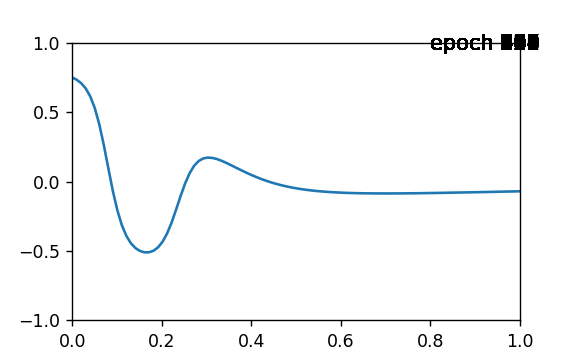

In [62]:
epochs = 500
fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(-1,1)
plot, = ax.plot(0,0)

def anim_frame(epoch):
    model.fit(x_data,y_data,verbose=0, epochs=1)
    plot.set_xdata(x)
    plot.set_ydata(model(x))
    plt.text(0.8,0.95,f"epoch {epoch}",fontsize="large",color="k")
    return plot,

anim = animation.FuncAnimation(fig,func=anim_frame, 
                               frames=epochs, interval=100)

In [ ]:
x = np.linspace(0,2,100)
x_data = []
y_data = []

fig, ax = plt.subplots()
ax.set_xlim(0,2)
ax.set_ylim(0,2)
plot, = ax.plot(x, x**1)

def anim_frame(i):
#     x_data.append()
    y = x**i
    plot.set_xdata(x)
    plot.set_ydata(y)
    plot.set_label(f'x^{i:.3f}')
    ax.legend()
    return line,

anim = animation.FuncAnimation(fig,func=anim_frame, 
                               frames=np.arange(1,10,0.01), interval=0.1)

## Loss function

In [8]:
x_phys = tf.linspace(0,1,30)
x_data_tf = tf.constant(x_data)
y_data_tf = tf.constant(y_data)

In [34]:
def total_loss(y_true, y_pred):
    sq = tf.square(y_true-y_pred)
    l_1 = tf.reduce_mean(sq)
    
    mu, k = d*2, w0**2
    with tf.GradientTape(persistent=True) as g:
        g.watch(x_phys)
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x_phys)
            y_phys = model(x_phys)
            
        dx = tf.cast(gg.gradient(y_phys,x_phys), dtype=tf.float32)
    dx2 = tf.cast(g.gradient(dx,x_phys), dtype=tf.float32)
    eqn = dx2 + mu*dx + k*tf.reshape(y_phys, [y_phys.shape[0],])
    l_2 = tf.cast((1e-6)*tf.reduce_mean(eqn**2), dtype=tf.float32)
    return l_1 + l_2
#     return eqn

# total_loss2(y_data,model(x_data_tf))

## Miscellaneous Functions

### progress bar

In [10]:
def progress_bar(progress, total, prompt=''):
    percent = (progress/float(total)) * 100
    bar = '#'*int(percent/2) + '-'*(50-int(percent/2))
    print(f"\r{prompt}{progress}/{total} |{bar}|  {percent:.1f}%", end='\r')

### function to plot the curve

In [25]:
def plot_curve(a,b,c, epoch):
    plt.plot(a,c,c='green', linewidth=3, label='model(x)')
    plt.plot(a,b,c='grey', linewidth=1, label='true soln')
    plt.legend(loc=(0.7,0.05), frameon=False, fontsize='large')
#     plt.axis('off')
    plt.text(0.8,0.95,f"epoch {epoch}",fontsize="large",color="k")

## To create GIF of the plots

In [ ]:
fps = 1000
img = [Image.open(file) for file in files]
img[0].save(fp=f'wave_final_fps{fps}.gif', format='GIF', append_images=img[1:], save_all=True, duration=int(1000/fps), loop=0)